In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy import integrate, stats
import pymc3 as pm
import corner
%matplotlib inline

## Loading the data

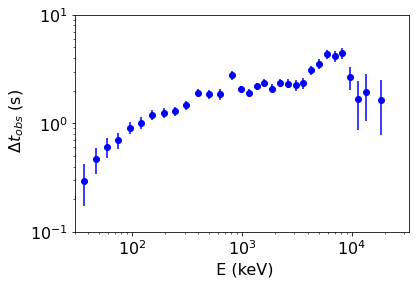

In [2]:
data = np.loadtxt("./data/time_lag_data_plot.txt")
E = data[:,0]
t_obs = data[:,1]
err = data[:,2]
plt.xscale("log")
plt.yscale("log")
plt.xlim(30,1E5/3)
plt.ylim(0.1,10)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel(r' E (keV)', fontsize=16)
plt.ylabel(r' $\Delta t_{obs}$ (s)', fontsize=16)
for a, b, c in zip(E, t_obs, err):
    if b>0:
        plt.errorbar(a, b, c, fmt='bo')

## The null hypothesis

Here we define the model for null hypothesis which has the free variables $\tau$ and $\alpha$. Labeling this model as $M_0$ we can say:

$$
y \sim \mathcal{N}(y_{M_0}, \sigma_y^2)
$$

After defining the model, we run the ADVI to approximate posterior for $y_{M_0}$ and draw traces of the free variables estimated by the model. The first thing to check is whether $ELBO$ has convereged or not. Then from the traces of free variables we generate values of $y_{M_0}$ by using the sample_ppc (ppc stands for *Predictive Posterior Check*) function of PYMC3 by supplying it with traces of our free variables. We then plot $y_{M_0}$ over the original data to see how well it models the data.

We repeat this for models where $n=1$ and $n=2$.

In [3]:
def sigmoid(x) : 
    return 1 / ( 1 + np.exp(-x))

'''
 In ADVI, the variational distribution is taken as gaussian with diagonal variance. p(x) ~ N(mu,std^2)
'''
def variational_pdf(x, mu, std, b, a) : 
    return stats.norm.pdf(x, mu, std) / ((b - a) * sigmoid(x) * (1 - sigmoid(x)))

In [4]:
E_0 = 11.34
H_0 = 67.3
O_M = 0.315
O_L = 1 - O_M
z = 1.41

def t1(x,tau,a):
    return (tau*(x**a - E_0**a))
ta, covar = curve_fit(t1, E, t_obs, sigma=err)

print(ta)

with pm.Model() as model_null:
    tau = pm.Uniform('tau',lower=0,upper=1)
    alpha = pm.Uniform('alpha',lower=0,upper=1)
    mu = tau * (E**alpha - E_0**alpha)
    y_obs = pm.Normal('y_obs',mu=mu,sd=err, observed=t_obs)

[5.8651346  0.05860812]


In [5]:

with model_null:
    advi = pm.ADVI()
    params = advi.fit(n=100000,obj_optimizer=pm.adam(learning_rate=5e-3),callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')])
    traces = pm.sample_approx(params,draws=1000)
    ppc = pm.sample_posterior_predictive(traces)

Average Loss = 46.65: 100%|██████████| 100000/100000 [00:15<00:00, 6356.03it/s]  
Finished [100%]: Average Loss = 46.657
100%|██████████| 1000/1000 [00:00<00:00, 1397.39it/s]


In [6]:
means_dict = params.bij.rmap(params.params[0].eval())
rho_dict = params.bij.rmap(params.params[1].eval())
std_dict ={k: np.log(1 + np.exp(v)) for k, v in rho_dict.items()}

In [7]:
model_null.vars

[tau_interval__, alpha_interval__]

In [8]:
def model_null_logp(trace):
    log_p = 0.
    log_p += stats.uniform.logpdf(trace['tau'],0,1)
    log_p += stats.uniform.logpdf(trace['tau'],0,1)
    mu = trace['tau'] * (E**trace['alpha'] - E_0**trace['alpha'])
    log_p += stats.norm.logpdf(t_obs,mu,err).sum()
    return log_p

model_null_logp_vec = np.vectorize(model_null_logp)

In [9]:
def q(trace,model):
    qw=1.
    l=0.
    u=1.
    for var in model.vars:
        var = str(var).split('~')[0].strip()
        qw *= variational_pdf(trace[str(var)],means_dict[str(var)], std_dict[str(var)],u,l)
        #print(qw)
    return qw
q_vec = np.vectorize(q)

In [10]:
# approximate evidence
approx_evidence = (np.exp(model_null_logp_vec(traces)) / q_vec(traces,model_null)).mean()
print('Approx evidence : ', approx_evidence)
print('log approx evidence : ', np.log(approx_evidence))

Approx evidence :  9.435807205262045e-21
log approx evidence :  -46.10977522336721


In [11]:
#ELBO
elbo_null = (model_null_logp_vec(traces) - np.log(q_vec(traces,model_null))).mean()
print(elbo_null)

-46.62207923866094


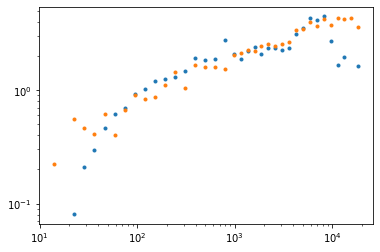

In [12]:
plt.xscale("log")
plt.yscale("log")
plt.plot(E,t_obs,'.')
plt.plot(E,ppc['y_obs'][-1],'.')

In [13]:
n = 1
def integrand(i):
    return ((1+i)**n/np.sqrt(O_M*(1+i)**3+O_L))
I1, e1 = integrate.quad(integrand, 0, z)
with pm.Model() as model_1:
    tau = pm.Uniform('tau',lower=0,upper=5)
    alpha = pm.Uniform('alpha',lower=0,upper=1)
    E_qg = pm.Uniform('E_qg',lower=0,upper=1e16)
    logEqg =  pm.Deterministic('logEqg', np.log(E_qg))
    mu = tau*(E**alpha - E_0**alpha) + (-(1+n)/(2*H_0*3.24))*(E**n-E_0**n)*(10**14)*I1/(E_qg**n)
    y_obs = pm.Normal('y_obs',mu=mu,sd=err, observed=t_obs)

In [14]:
with model_1:
    advi = pm.ADVI()

In [15]:
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval  # callable that returns std
)

In [16]:
with model_1:
    params_1 = advi.fit(n=2500000,obj_optimizer=pm.adam(learning_rate=5e-4),callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute'), tracker])
    traces_1 = pm.sample_approx(params_1,draws=1000)
    ppc_1 = pm.sample_posterior_predictive(traces_1)

Average Loss = 30.76:   3%|▎         | 78999/2500000 [00:14<07:36, 5306.29it/s]     
Convergence achieved at 79000
Interrupted at 78,999 [3%]: Average Loss = 7.4792e+05
100%|██████████| 1000/1000 [00:00<00:00, 1583.61it/s]


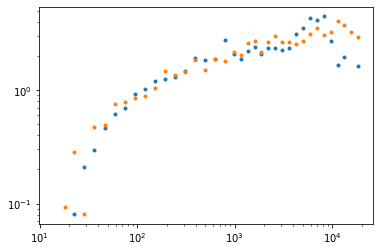

In [17]:
plt.xscale("log")
plt.yscale("log")
plt.plot(E,t_obs,'.')
plt.plot(E,ppc_1['y_obs'][-1],'.')


In [18]:
means_dict = params_1.bij.rmap(params_1.params[0].eval())
rho_dict = params_1.bij.rmap(params_1.params[1].eval())
std_dict ={k: np.log(1 + np.exp(v)) for k, v in rho_dict.items()}

print(means_dict)
print(std_dict)

{'tau_interval__': array(-0.93909414), 'alpha_interval__': array(-1.64272525), 'E_qg_interval__': array(0.21302924)}
{'tau_interval__': 0.024149111405336477, 'alpha_interval__': 0.011474591091344358, 'E_qg_interval__': 0.26998728345831213}


In [19]:
def model1_logp(trace):
    n=1
    log_p = 0.
    log_p += stats.uniform.logpdf(trace['tau'],0.,5.)
    log_p += stats.uniform.logpdf(trace['alpha'],0.,1.)
    log_p += stats.uniform.logpdf(trace['E_qg'],0.,1e16)
    mu = trace['tau'] * (E**trace['alpha'] - E_0**trace['alpha']) + (-(1+n)/(2*H_0*3.24))*(E**n-E_0**n)*(10**14)*I1/(trace['E_qg']**n)
    log_p += stats.norm.logpdf(t_obs,mu,err).sum()
    return log_p
model1_logp_vec = np.vectorize(model1_logp)

In [20]:
def q(trace,model):
    qw=1.
    l=0.
    u=1.
    for var in model.vars:
        var = str(var).split('~')[0].strip()
        if(str(var)[:len(str(var)) - len("_interval__")]) == 'alpha':
            l =0.
            u = 1.
            #print(str(var))
        elif (str(var)[:len(str(var)) - len("_interval__")]) == 'tau':
            l = 0.
            u = 5.
            #print(str(var))
        elif (str(var)[:len(str(var)) - len("_interval__")]) == 'E_qg':
            l = 0.
            u = 1e16
            #print(str(var))
        qw *= variational_pdf(trace[str(var)],means_dict[str(var)], std_dict[str(var)],u,l)
    return qw
q_vec = np.vectorize(q)

In [21]:
# approximate evidence
approx_evidence_1 = (np.exp(model1_logp_vec(traces_1)) / q_vec(traces_1,model_1)).mean()
print('Approx evidence : ', approx_evidence_1)
print('log approx evidence : ', np.log(approx_evidence_1))

Approx evidence :  1.1871494616595782e-13
log approx evidence :  -29.76205118575454


In [22]:
#ELBO
elbo_1 = (model1_logp_vec(traces_1) - np.log(q_vec(traces_1,model_1))).mean()
print(elbo_1)

-30.578153130493178


In [23]:
with model_1:
    traces_1 = pm.sample_approx(params_1,draws=10000)

In [24]:
stats.uniform.pdf(1.5,1,1)

1.0

In [25]:
pm.summary(traces_1)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
tau,1.405000e+00,2.500000e-02,1.360000e+00,1.452000e+00,0.000000e+00,0.000000e+00,9297.0,9297.0,9299.0,9784.0,NaN
alpha,1.620000e-01,2.000000e-03,1.590000e-01,1.650000e-01,0.000000e+00,0.000000e+00,9934.0,9934.0,9963.0,9725.0,NaN
E_qg,5.529004e+15,6.557485e+14,4.286833e+15,6.739315e+15,6.532406e+12,4.626738e+12,10077.0,10044.0,10067.0,9870.0,NaN
logEqg,3.624200e+01,1.210000e-01,3.600900e+01,3.645800e+01,1.000000e-03,1.000000e-03,10107.0,10107.0,10067.0,9870.0,NaN


In [26]:
n = 2
def integrand(i):
    return ((1+i)**n/np.sqrt(O_M*(1+i)**3+O_L))
I2, e2 = integrate.quad(integrand, 0, z)
with pm.Model() as model_2:
    tau = pm.Uniform('tau',lower=1,upper=5)
    alpha = pm.Uniform('alpha',lower=0,upper=0.19)
    E_qg = pm.Uniform('E_qg',lower=0,upper=1e8)
    Eqg_log = pm.Deterministic('logEqg', np.log(E_qg))
    mu = tau*(E**alpha - E_0**alpha) + (-(1+n)/(2*H_0*3.24))*(E**n-E_0**n)*(10**8)*I2/(E_qg**n)
    y_obs = pm.Normal('y_obs',mu=mu,sd=err, observed=t_obs)

In [27]:
with model_2:
    advi = pm.ADVI()

In [28]:
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval  # callable that returns std
)


In [29]:
with model_2:
    params_2 = advi.fit(n=2500000,obj_optimizer=pm.adam(learning_rate=5e-4),callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute'), tracker])
    traces_2 = pm.sample_approx(params_2,draws=10000)
    ppc_2 = pm.sample_posterior_predictive(traces_2)

Average Loss = 27.274:   6%|▌         | 142599/2500000 [00:26<07:20, 5355.75it/s]
Convergence achieved at 142600
Interrupted at 142,599 [5%]: Average Loss = 36.569
100%|██████████| 10000/10000 [00:06<00:00, 1638.73it/s]


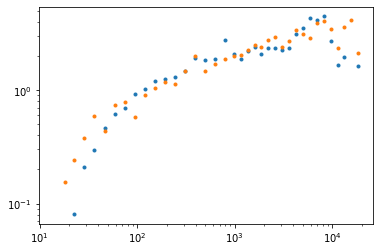

In [30]:
plt.xscale("log")
plt.yscale("log")
plt.plot(E,t_obs,'.')
plt.plot(E,ppc_2['y_obs'][-1],'.')

In [31]:
means_dict = params_2.bij.rmap(params_2.params[0].eval())
rho_dict = params_2.bij.rmap(params_2.params[1].eval())
std_dict ={k: np.log(1 + np.exp(v)) for k, v in rho_dict.items()}

print(means_dict)
print(std_dict)

{'alpha_interval__': array(0.03103987), 'tau_interval__': array(0.03907811), 'E_qg_interval__': array(-1.59815594)}
{'alpha_interval__': 0.026238484722993033, 'tau_interval__': 0.058810859511865224, 'E_qg_interval__': 0.14843613678672768}


In [32]:
def model2_logp(trace):
    n=2
    log_p = 0.
    log_p += stats.uniform.logpdf(trace['tau'],1.,4.)
    log_p += stats.uniform.logpdf(trace['alpha'],0.,0.19)
    log_p += stats.uniform.logpdf(trace['E_qg'],0.,1e8)
    mu = trace['tau'] * (E**trace['alpha'] - E_0**trace['alpha']) +(-(1+n)/(2*H_0*3.24))*(E**n-E_0**n)*(10**8)*I2/(trace['E_qg']**n)
    log_p += stats.norm.logpdf(t_obs,mu,err).sum()
    return log_p
model2_logp_vec = np.vectorize(model2_logp)

In [33]:
def q(trace,model):
    qw=1.
    l=0.
    u=0.19
    for var in model.vars:
        var = str(var).split('~')[0].strip()
        #print(str(var))
        if(str(var)[:len(str(var)) - len("_interval__")]) == 'alpha':
            l =0.
            u = 0.189
        elif (str(var)[:len(str(var)) - len("_interval__")]) == 'tau':
            l = 1.
            u = 5.
        elif (str(var)[:len(str(var)) - len("_interval__")]) == 'E_qg':
            l = 0.
            u = 1e8
        qw *= variational_pdf(trace[str(var)],means_dict[str(var)], std_dict[str(var)],u,l)
        #print(qw)
    return qw
q_vec = np.vectorize(q)

In [34]:
# approximate evidence
approx_evidence_2 = (np.exp(model2_logp_vec(traces_2)) / q_vec(traces_2,model_2)).mean()
print('Approx evidence : ', approx_evidence_2)
print('log approx evidence : ', np.log(approx_evidence_2))

Approx evidence :  3.745407238798055e-12
log approx evidence :  -26.310490762869197


In [35]:
#ELBO
elbo_2 = (model2_logp_vec(traces_2) - np.log(q_vec(traces_2,model_2))).mean()
print(elbo_2)

-27.27602029565064


In [36]:
with model_2:
    traces_2 = pm.sample_approx(params_2,draws=10000)

In [37]:
pm.summary(traces_2)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
tau,3.039000e+00,0.058,2.928000e+00,3.144000e+00,0.001,0.000,9532.0,9509.0,9538.0,9263.0,NaN
alpha,9.600000e-02,0.001,9.400000e-02,9.900000e-02,0.000,0.000,10081.0,10081.0,10080.0,10046.0,NaN
E_qg,1.695405e+07,2100066.119,1.320832e+07,2.100601e+07,21086.789,14929.061,9918.0,9895.0,9940.0,9612.0,NaN
logEqg,1.663800e+01,0.124,1.640900e+01,1.687000e+01,0.001,0.001,9938.0,9937.0,9940.0,9612.0,NaN


Now we have all three models we can do model selection. Here we investigate two ways of  model selection : $WAIC$ and $Bayes Factor$.
We use the PYMC3's *compare* functioin to get WAIC for the three models and it supports model with n=2. Next we calculate the Bayes Factor. We find the *Odd's ratio* as:

$$
O_{21} \equiv \frac{P(M_2~|~D)}{P(M_1~|~D)} = \frac{P(D~|~M_2)}{P(D~|~M_1)}\frac{P(M_2)}{P(M_1)}
$$

Here the ratio $P(M_2) / P(M_1)$ is the *prior odds ratio*, and is often assumed to be equal to 1 if no compelling prior evidence favors one model over another.
The ratio $P(D~|~M_2) / P(D~|~M_1)$ is the *Bayes factor*, and is the key to Bayesian model selection.

The Bayes factor can be computed by evaluating the integral over the parameter likelihood:

$$
P(D~|~M) = \int_\Omega P(D~|~\theta, M) P(\theta~|~M) d\theta
$$

This integral is over the entire parameter space of the model, and thus can be extremely computationally intensive, especially as the dimension of the model grows beyond a few.

However, PYMC3 supplies us with log joint likelihood of the model as *logp* function. So we can approximate $P(D~|~M)$ as the mean of exponentiation of this joint likelihood:

$$
P(D~|~M) = 1/n\sum_{i=1}^n P(D~|~\theta_i, M) P(\theta_i~|~M) 
$$

In [38]:
print(approx_evidence_1/approx_evidence)
print(approx_evidence_2/approx_evidence)
print(approx_evidence_1/approx_evidence_2)
print(approx_evidence_2/approx_evidence_1)

12581323.842623059
396935541.1065799
0.03169613838949455
31.549584612220226


In [39]:
traces_1 = pm.sample_approx(params_1,draws=5000)

/home/geethu/miniconda3/envs/vipaperenv/lib/python3.7/site-packages/corner/corner.py:806: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)
/home/geethu/miniconda3/envs/vipaperenv/lib/python3.7/site-packages/corner/corner.py:806: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)
/home/geethu/miniconda3/envs/vipaperenv/lib/python3.7/site-packages/corner/corner.py:806: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)


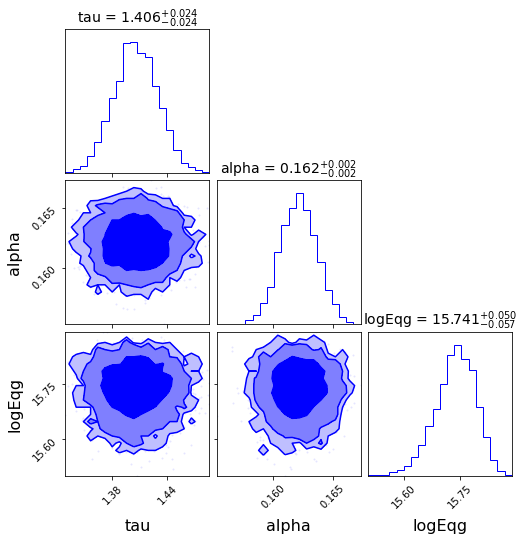

In [40]:
dn = np.asarray([traces_1['tau'],traces_1['alpha'],traces_1['logEqg']/np.log(10)]).T
#corner.corner(dn,labels=["tau", "alpha","logEqg"])
corner.corner(dn, labels=["tau", "alpha","logEqg"] ,levels=(0.68,0.95,0.99),color = 'b',alpha=0.1,fill_contours = 1,show_titles=True,title_fmt='.3f',max_n_ticks = 3, title_kwargs={"fontsize": 14},label_kwargs={"fontsize": 16},contour_kwargs={"color": 'r'})
plt.savefig('n_1.png')

In [41]:
traces_2 = pm.sample_approx(params_2,draws=5000)

/home/geethu/miniconda3/envs/vipaperenv/lib/python3.7/site-packages/corner/corner.py:806: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)
/home/geethu/miniconda3/envs/vipaperenv/lib/python3.7/site-packages/corner/corner.py:806: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)
/home/geethu/miniconda3/envs/vipaperenv/lib/python3.7/site-packages/corner/corner.py:806: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)


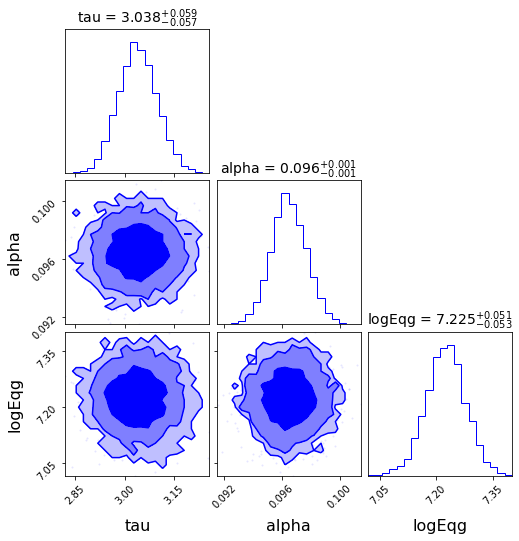

In [42]:
dn = np.asarray([traces_2['tau'],traces_2['alpha'],traces_2['logEqg']/np.log(10)]).T
#corner.corner(dn,labels=["tau", "alpha","logEqg"])
corner.corner(dn, labels=["tau", "alpha","logEqg"] ,levels=(0.68,0.95,0.99),color = 'b',alpha=0.1,fill_contours = 1,show_titles=True,title_fmt='.3f',max_n_ticks = 3, title_kwargs={"fontsize": 14},label_kwargs={"fontsize": 16},contour_kwargs={"color": 'r'})
plt.savefig("n_2.png")

# nestle

In [43]:
import nestle

In [44]:
%%time
n = 1
def loglike(P):
    mu = P[0]*(E**P[1] - E_0**P[1]) + (-(1+n)/(2*H_0*3.24))*(E**n-E_0**n)*(10**14)*I1/(P[2]**n)
    return sum(stats.norm.logpdf(*args) for args in zip(t_obs,mu,err))

def prior_transform(P):
    return np.array([5.*P[0],P[1],1e16*P[2]])

result_1 = nestle.sample(loglike, prior_transform, 3)

print(result_1.logz)     # log evidence
print(result_1.logzerr)

-26.529419156698523
0.24928482595140108
CPU times: user 57.4 s, sys: 98.6 ms, total: 57.5 s
Wall time: 57.2 s


In [45]:
%%time
n = 2
def loglike(P):
    mu = P[0]*(E**P[1] - E_0**P[1]) + (-(1+n)/(2*H_0*3.24))*(E**n-E_0**n)*(10**8)*I2/(P[2]**n)
    return sum(stats.norm.logpdf(*args) for args in zip(t_obs,mu,err))

def prior_transform(P):
    return np.array([4.*P[0] + 1.,0.19*P[1],1e8*P[2]])

result_2 = nestle.sample(loglike, prior_transform, 3)

print(result_2.logz)     # log evidence
print(result_2.logzerr)

-24.044890529622155
0.24239140120985234
CPU times: user 34.9 s, sys: 145 ms, total: 35.1 s
Wall time: 34.8 s


In [46]:
%%time
def loglike(P):
    mu = P[0]*(E**P[1] - E_0**P[1]) 
    return sum(stats.norm.logpdf(*args) for args in zip(t_obs,mu,err))

def prior_transform(P):
    return np.array([P[0],P[1]])

result_0 = nestle.sample(loglike, prior_transform, 2)

print(result_0.logz)     # log evidence
print(result_0.logzerr)

-45.88728231256574
0.26678025160638985
CPU times: user 7.28 s, sys: 75.5 ms, total: 7.35 s
Wall time: 7.26 s


In [47]:
print("Nestle:")
print("n_1/null : ")
print(np.exp(result_1.logz)/np.exp(result_0.logz))
print("n_2/null : ")
print(np.exp(result_2.logz)/np.exp(result_0.logz))
print("n_1/n_2 : ")
print(np.exp(result_1.logz)/np.exp(result_2.logz))
print("n_2/n_1 : ")
print(np.exp(result_2.logz)/np.exp(result_1.logz))
print((result_2.logz-result_1.logz) / np.log(10))

Nestle:
n_1/null : 
255277859.72433615
n_2/null : 
3062176525.596456
n_1/n_2 : 
0.08336484118093508
n_2/n_1 : 
11.995464584759414
1.079017072869929


In [48]:
print("Pymc3:")
print("n_1/null : ")
print(approx_evidence_1/approx_evidence)
print(np.log(approx_evidence_1/approx_evidence) / np.log(10))
print("n_2/null : ")
print(approx_evidence_2/approx_evidence)
print(np.log(approx_evidence_2/approx_evidence) / np.log(10))
print("n_1/n_2 : ")
print(approx_evidence_1/approx_evidence_2)
print("n_2/n_1 : ")
print(approx_evidence_2/approx_evidence_1)
print(np.log(approx_evidence_2/approx_evidence_1) / np.log(10))

Pymc3:
n_1/null : 
12581323.842623059
7.099726341212331
n_2/null : 
396935541.1065799
8.59871998682709
n_1/n_2 : 
0.03169613838949455
n_2/n_1 : 
31.549584612220226
1.4989936456147586
